#Análisis de la Red de Museos de Buenos Aires
Este proyecto, desarrollado para la materia Álgebra Lineal Computacional (Facultad de Ciencias Exactas y Naturales, UBA), aplica conceptos de álgebra lineal y ciencia de redes para analizar la red de museos de la Ciudad de Buenos Aires. El objetivo es modelar el comportamiento de los visitantes durante "La Noche de los Museos" y descubrir la estructura subyacente de la red.
El análisis se divide en dos partes principales.

#Parte 1: Ranking de Museos con PageRank
En esta primera parte, el objetivo fue determinar la "centralidad" o "relevancia" de cada museo dentro de la red. La hipótesis es que los museos más importantes son aquellos a los que es más probable llegar siguiendo un recorrido lógico por la ciudad.
###¿Qué se hizo?
####Construcción de la Red: Se creó un grafo dirigido donde los museos son los nodos y una arista conecta un museo con sus m vecinos más cercanos geográficamente.
####Modelo de Transición: Se construyó una matriz estocástica que representa la probabilidad de que un visitante se mueva de un museo a otro.
####Algoritmo PageRank: Se adaptó el famoso algoritmo de Google para calcular un puntaje de relevancia para cada museo. La ecuación principal p = (1-α)Cp + (α/N)1 se resolvió para encontrar el vector de rankings p.
####Implementación Numérica: La resolución del sistema de ecuaciones lineales se realizó implementando la factorización LU desde cero, sin utilizar las funciones de alto nivel de librerías como numpy.linalg.inv.
El resultado es un ranking que identifica a los museos más centrales y un análisis de cómo esta centralidad cambia al modificar los parámetros del modelo.

#Parte 2: Detección de Comunidades con Métodos Espectrales
La segunda parte se centró en identificar "comunidades": grupos de museos que están fuertemente conectados entre sí pero débilmente conectados con el resto. Esto permite entender la estructura geográfica y temática de la red.
###¿Qué se hizo?
Se implementaron dos métodos clásicos de clustering espectral basados en los autovectores de matrices clave:
####Corte Mínimo (Minimum Cut): Utiliza el segundo autovector más pequeño de la matriz Laplaciana (L) del grafo para dividir la red en dos, minimizando las conexiones entre los grupos.
####Maximización de la Modularidad: Emplea el autovector principal de la matriz de Modularidad (R) para encontrar particiones donde las conexiones internas son significativamente más densas de lo que se esperaría por azar.
####Partición Recursiva: Ambos métodos se aplicaron de forma iterativa para poder identificar más de dos comunidades en la red.
####Implementación Numérica: Para encontrar los autovectores necesarios, se implementaron el Método de la Potencia y sus variantes (método inverso y deflación de Hotelling).

El análisis finaliza con una visualización de estas comunidades en el mapa de Buenos Aires, comparando los resultados de ambos enfoques y extrayendo conclusiones sobre la organización espacial de los museos.
###Tecnologías y Conceptos Clave
####Librerías:
 NumPy, SciPy, Pandas, Geopandas, Matplotlib, NetworkX
###Conceptos de Álgebra Lineal:
Factorización LU, Autovectores y Autovalores, Matrices Estocásticas, Matriz Laplaciana.
###Algoritmos:
PageRank, Método de la Potencia (y variantes), Clustering Espectral.


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [ ]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import importlib.util
import sys
import matplotlib.patches as mpatches




ruta = "/content/TP1_EJM_TN_template_funciones.py"
nombre_modulo = "f"

spec = importlib.util.spec_from_file_location(nombre_modulo, ruta)
f = importlib.util.module_from_spec(spec)
sys.modules[nombre_modulo] = f
spec.loader.exec_module(f)



ruta2 = "/content/TP2_EJM_TN_template_funciones_2.py"
nombre_modulo2 = "f2"

spec2 = importlib.util.spec_from_file_location(nombre_modulo2, ruta2)
f2 = importlib.util.module_from_spec(spec2)
sys.modules[nombre_modulo2] = f2
spec2.loader.exec_module(f2)






# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

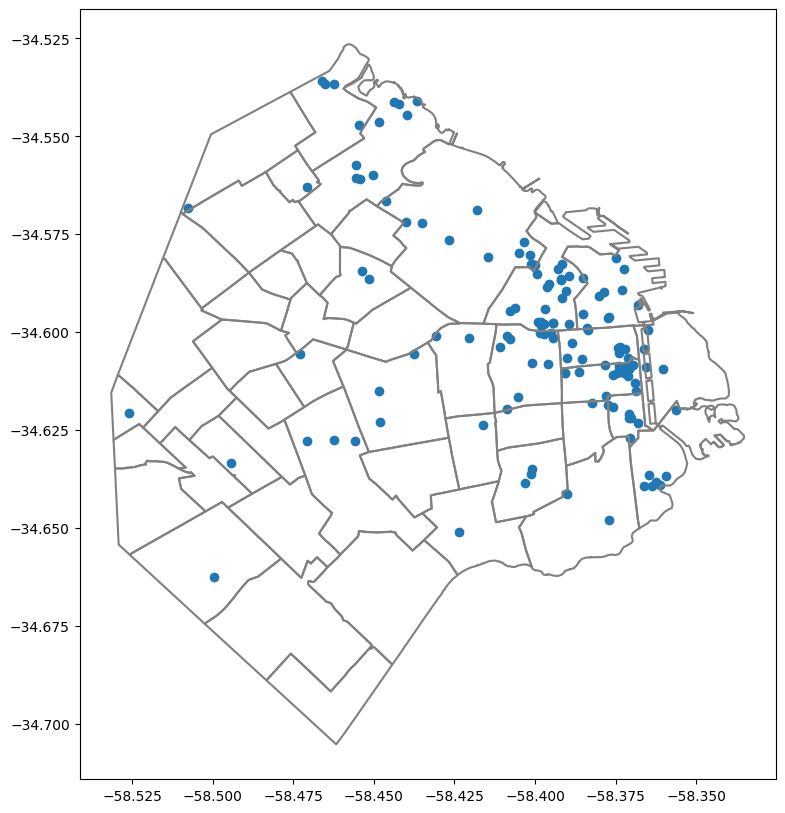

In [ ]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [ ]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [ ]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [ ]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

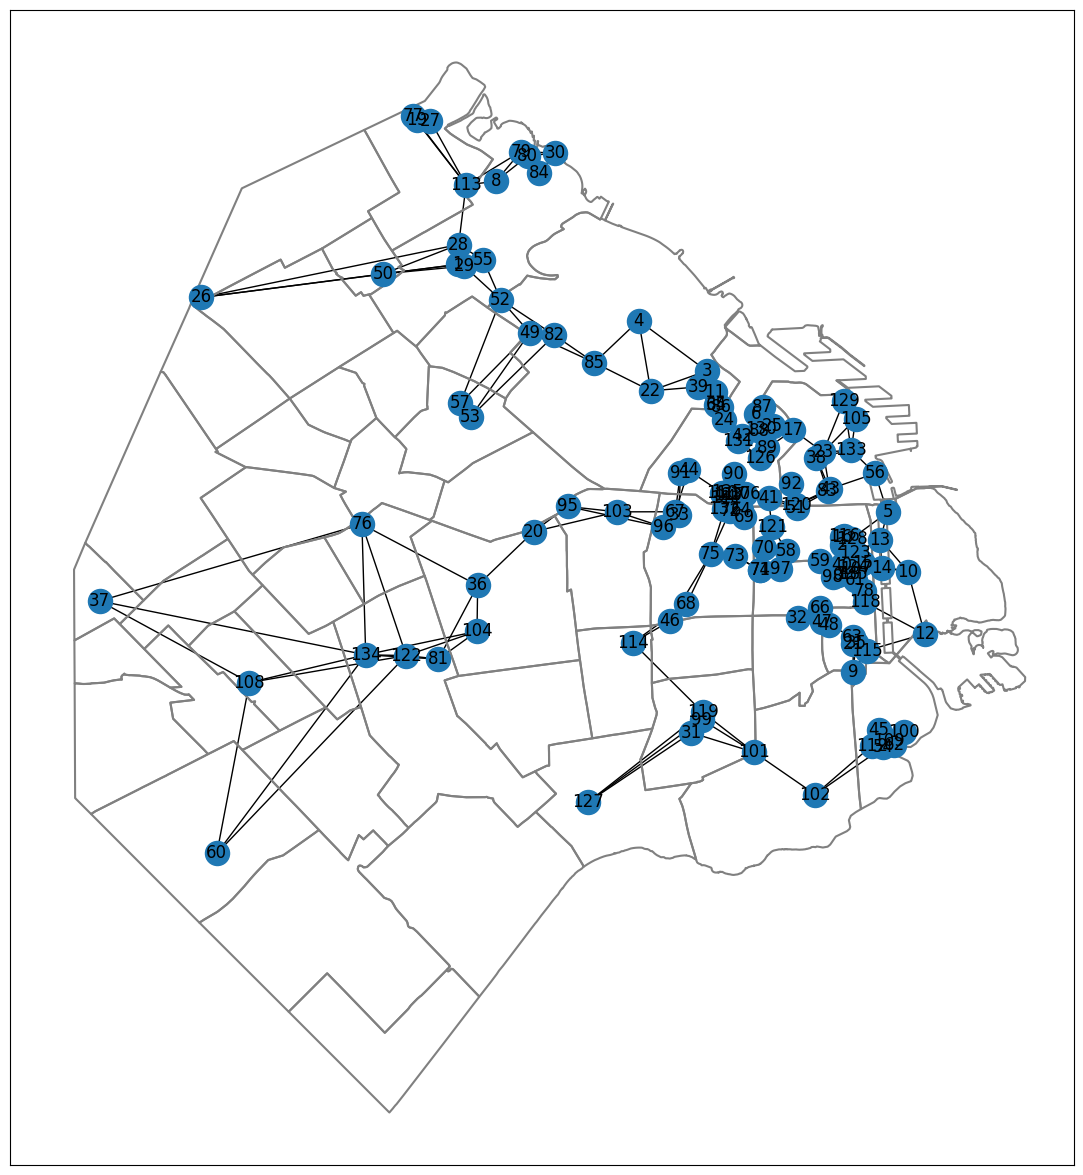

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Parte 1

## Punto 1:
Partiendo de la ecuación (3):

$ p = (1-\alpha)Cp+a\cdot \frac{1}{N}\cdot 1 $

Restando $(1-\alpha)Cp$ de ambos lados obtenemos.

$ p - (1-\alpha)Cp = a\cdot \frac{1}{N}\cdot 1 $

Factorizamos $p$ a la izquierda

$ (I - (1-\alpha)C)p = a\cdot \frac{1}{N}\cdot 1 $

Multiplicamos por $\frac{N}{a}$ por izquierda a ambos lados ($\alpha \neq 0$)

$ \frac{N}{a}(I - (1-\alpha)C)p = 1 $

Teniendo en cuenta que
$ \frac{N}{a}(I - (1-\alpha)C) = M \wedge 1 = b$

obtenemos

$Mp = b$


## Punto 2 CORREGIDO:

Para la demostración del punto 2, que $Mp = b$ tiene solución única, necesitamos demostrar que $M$ es invertible. Ya que si existe $M^{-1}$,  obtenemos $p$ calculando

$p = M^{-1} . b$.

Sea:

$M = \frac{N}{a}(I-(1-\alpha)C)$,

Con $\frac{N}{a}$ un escalar distinto de 0, ya que la cantidad de Museos $N$  es mayor a 0 y $a  {\neq} 0$.

Por lo tanto, podemos decir que $\frac{N}{a}(I-(1-\alpha)C)$ es inverible si y solo si $I-(1-\alpha)C$ es invertible.


Por la proposición 4.2 del apunte tenemos que:

*Sea $A ∈ R ^{n×n}$ y EDD, entonces $A$ es invertible*

Además, sabemos que para una matriz cuadrada $A$,

 $det(A) = det(A^T)$.

 Como consecuencia, podemos saber que $A$ es invertible si su transupuesta lo es, y ya que una matriz $A$ es invertible cuando

  $det(A) \neq 0$
  
   entonces si $det(A^T) \neq 0$, tenemos que $A$ será invertible.


Retomando la demostración, quedamos en que queríamos ver si $M = I-(1-\alpha)C$ es una matriz no singular.

Por lo mencionado anteriormente, intentaremos probar que  $M^T = (I-(1-\alpha)C)^T$ es invertible, es decir, fijandonos que es $EED$ por filas, ya que estamos usando su transupuesta.

Comenzamos,

 Tenemos que $(I-(1-\alpha)C)^T$ = $I-(1-\alpha)C^T$,

 Ya que $I^{T} = I$ y $(1-\alpha)$ es un numero real





Luego, la matriz $C$ está definida como $C_{ij} = \frac{A_{ji} }{k}$.

Donde $A_{ji} = 1$ cuando el museo i está entre los $k$ museos más cercanos.

Como se menciona en el apartado de representación algebráica, tenemos que $C$ es estocásitca por columas, ya que todas sus columnas suman $1$.

Y para $C^T$, por lo tanto, sabremos que es estocásitca por filas.

Observamos luego que $M^T$ tiene la siguiente estructura:


Teniendo en cuenta que ningún museo se conecta a si mismo, se tiene que

 $C_{jj}^T = 0, \forall j \in [0,n)$
- Por lo que tenemos que para los elementos diagonales de $M$:

$M_{i,i} = \underbrace{I}_{1 }  - \underbrace{(1-\alpha)C_{jj}}_{0 } = 1$



- Y para los elementos no diagonales de $M$:  

$M_{i,j} = -(1-\alpha)C_{ji}^T$, con $i \neq  j$


Luego, para demostrar que es estrictamente diagonal dominante, tenemos que demostrar que para cada fila, el modulo del elemento de la diagonal, es mayor a la suma de los módulos de los otros elementos.


Esto, equivale a que:

$\sum_{j = 0, j \neq i}^{N}|M_{i,j}| < |M_{i,i}| $

Entonces, como $(1-\alpha)$ es un escalar entre 0 y 1 nos queda:

$(1-\alpha)\sum_{j = 0, j \neq i}^{N}|C_{ji}^T| < |1| $

Como mencionamos por su condicion de estocástica, la sumatoria de los elementos de una fila de $C^T$, es equivalente a 1, contemplando que $C_{jj}^T = 0$.

Por lo que la desigualdad nos queda

$(1-\alpha)|1| < |1| $

Es decir,

 $1-\alpha < 1$

Y esto vale siempre para $0 < \alpha < 1$, como queríamos demostrar.

Por lo descrito, demostramos que $M^T$ es diagonal dominate por filas y por lo tanto es invertible. Lo que implica que $M$ también es invertible.

Entonces podemos afirmar que la ecuación $M.p = b$ tiene solución única.











## Punto 3:

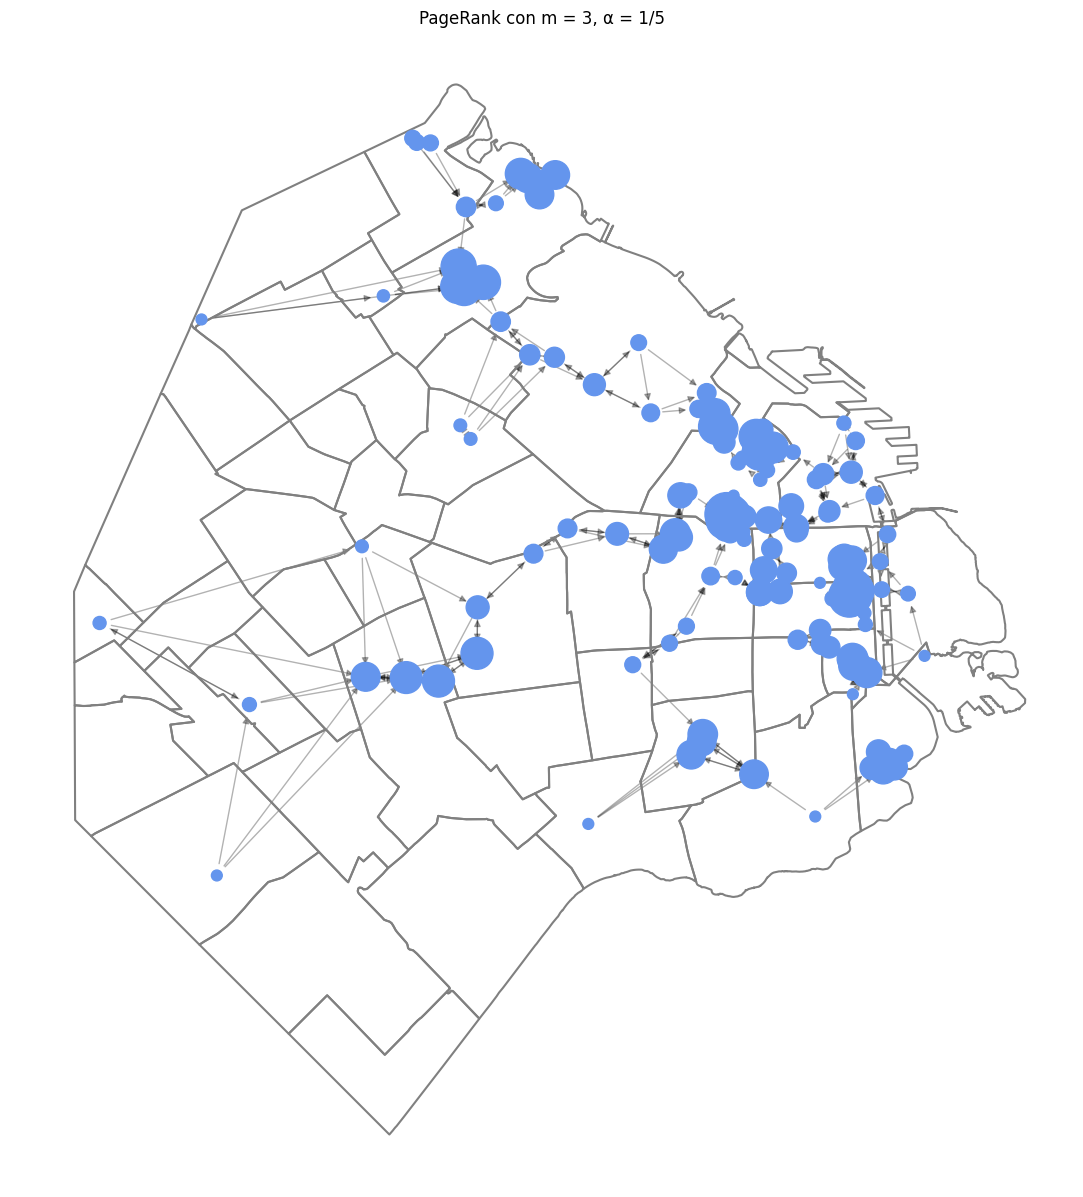

In [ ]:
#Punto 3.a.1

# Parámetros
m = 3
alfa = 1/5

A = construye_adyacencia(D, m)
p = f.calcula_pagerank(A, alfa)

# Armado del grafo
G = nx.from_numpy_array(A, create_using=nx.DiGraph)  # red dirigida
coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: v for i, v in enumerate(zip(coords['x'], coords['y']))}

# Normalización del tamaño de nodos
sizes = 1000 * (p / np.max(p))

# Visualización
fig, ax = plt.subplots(figsize=(15, 15))
barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)
nx.draw_networkx_nodes(G, G_layout, node_size=sizes, node_color='cornflowerblue', ax=ax)
nx.draw_networkx_edges(G, G_layout, alpha=0.3, ax=ax)
plt.title("PageRank con m = 3, α = 1/5")
plt.axis('off')
plt.show()

In [ ]:
#Punto 3.b.1

valores_m = [1, 3, 5, 10]
alfa = 1/5
pageranks_por_m = {}

for m in valores_m:
    A = construye_adyacencia(D, m)
    p = f.calcula_pagerank(A, alfa)
    pageranks_por_m[m] = p

In [ ]:
# Punto 3.c.1 variando a

valores_alfa = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
m = 5
pageranks_por_alfa = {}

A = construye_adyacencia(D, m)
for alfa in valores_alfa:
    p = f.calcula_pagerank(A, alfa)
    pageranks_por_alfa[alfa] = p


In [ ]:
#3.a.2


valores_m = [1, 3, 5, 10]
alfa = 1/5
pageranks_por_m = {}
top_museos_por_m = {}

for m in valores_m:
    A = construye_adyacencia(D, m)
    p = f.calcula_pagerank(A, alfa)
    pageranks_por_m[m] = p
    top_indices = np.argsort(p)[-3:][::-1]  # orden descendente
    top_museos_por_m[m] = top_indices

# Crear tabla legible
tabla_top_museos = pd.DataFrame.from_dict(top_museos_por_m, orient='index',
                                           columns=['Top 1', 'Top 2', 'Top 3'])

print("Top 3 Museos según la cantidad de museos cercanos:")
display(tabla_top_museos)


Top 3 Museos según la cantidad de museos cercanos:


Top 1  Top 2  Top 3
1      65    107     34
3     117    125     18
5      93    125    117
10    124    135     15

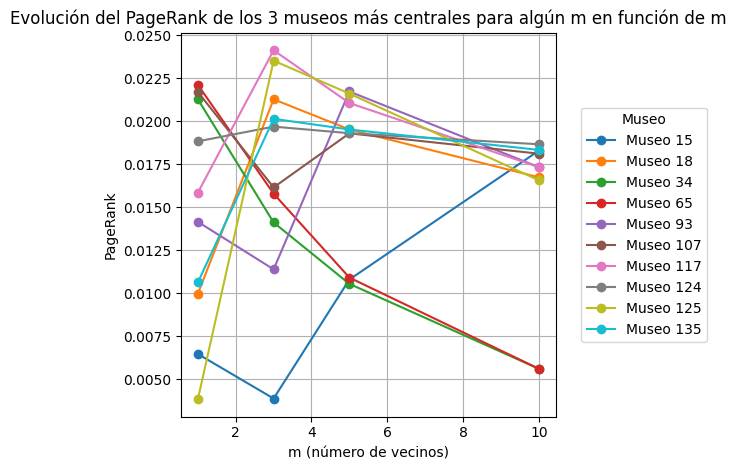

In [ ]:
#Juntamos todos los museos que fueron top 3

museos_centrales = set()
for indices in top_museos_por_m.values():
    museos_centrales.update(indices)


museos_centrales = sorted(list(museos_centrales))

#Armar DataFrame con los valores de PageRank de esos museos
df_evolucion = pd.DataFrame(
    {f"Museo {i}": [pageranks_por_m[m][i] for m in valores_m] for i in museos_centrales},
    index=valores_m
)



df_evolucion.plot(marker='o')
plt.xlabel("m (número de vecinos)")
plt.ylabel("PageRank")
plt.title("Evolución del PageRank de los 3 museos más centrales para algún m en función de m")
plt.grid(True)
plt.legend(title="Museo", loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()
plt.show()

## Análisis de los cambios de posiciones en función del aumento de vecinos más cercanos

En el gráfico de arriba podemos observar los museos que fueron rankeados para algún m entre los 3 museos más importantes. Podemos ver que la posición de pangerank se modifica batante, y su puntaje de pagerank también.
Para entender que está pasando realizamos (abajo) un gráfico para ver la ubicación de dichos museos.


Podemos observar que los museos que están en el borde entre Recoleta y Palermo, cerca de las avenidas las Heras y Libertador, están muy por encima en el ranking cuando se usan pocos vecinos más cercanos pero bajan drasticamente en comparación a otros museos más céntricos cuando se usan más vecinos más cercanos.

Suponemos que estos cambios se debe a que hay varios museos por esa zona, pero hay muchos más en la zona más céntrica (al sur de Recoleta). Estos museos de la zona más céntrica están linkeados por muchos más museos que también son importantes y por eso suben de posición comparativamente cuando se agregan más museos vecinos.

En otras palabras, los museos que están entre Recoleta y Palermo son bastante importantes, pero en otra zona (al sur de Recoleta), que hay más cantidad de museos importantes, el ranking en page rank aumenta cuando aumenta el número de vecinos.

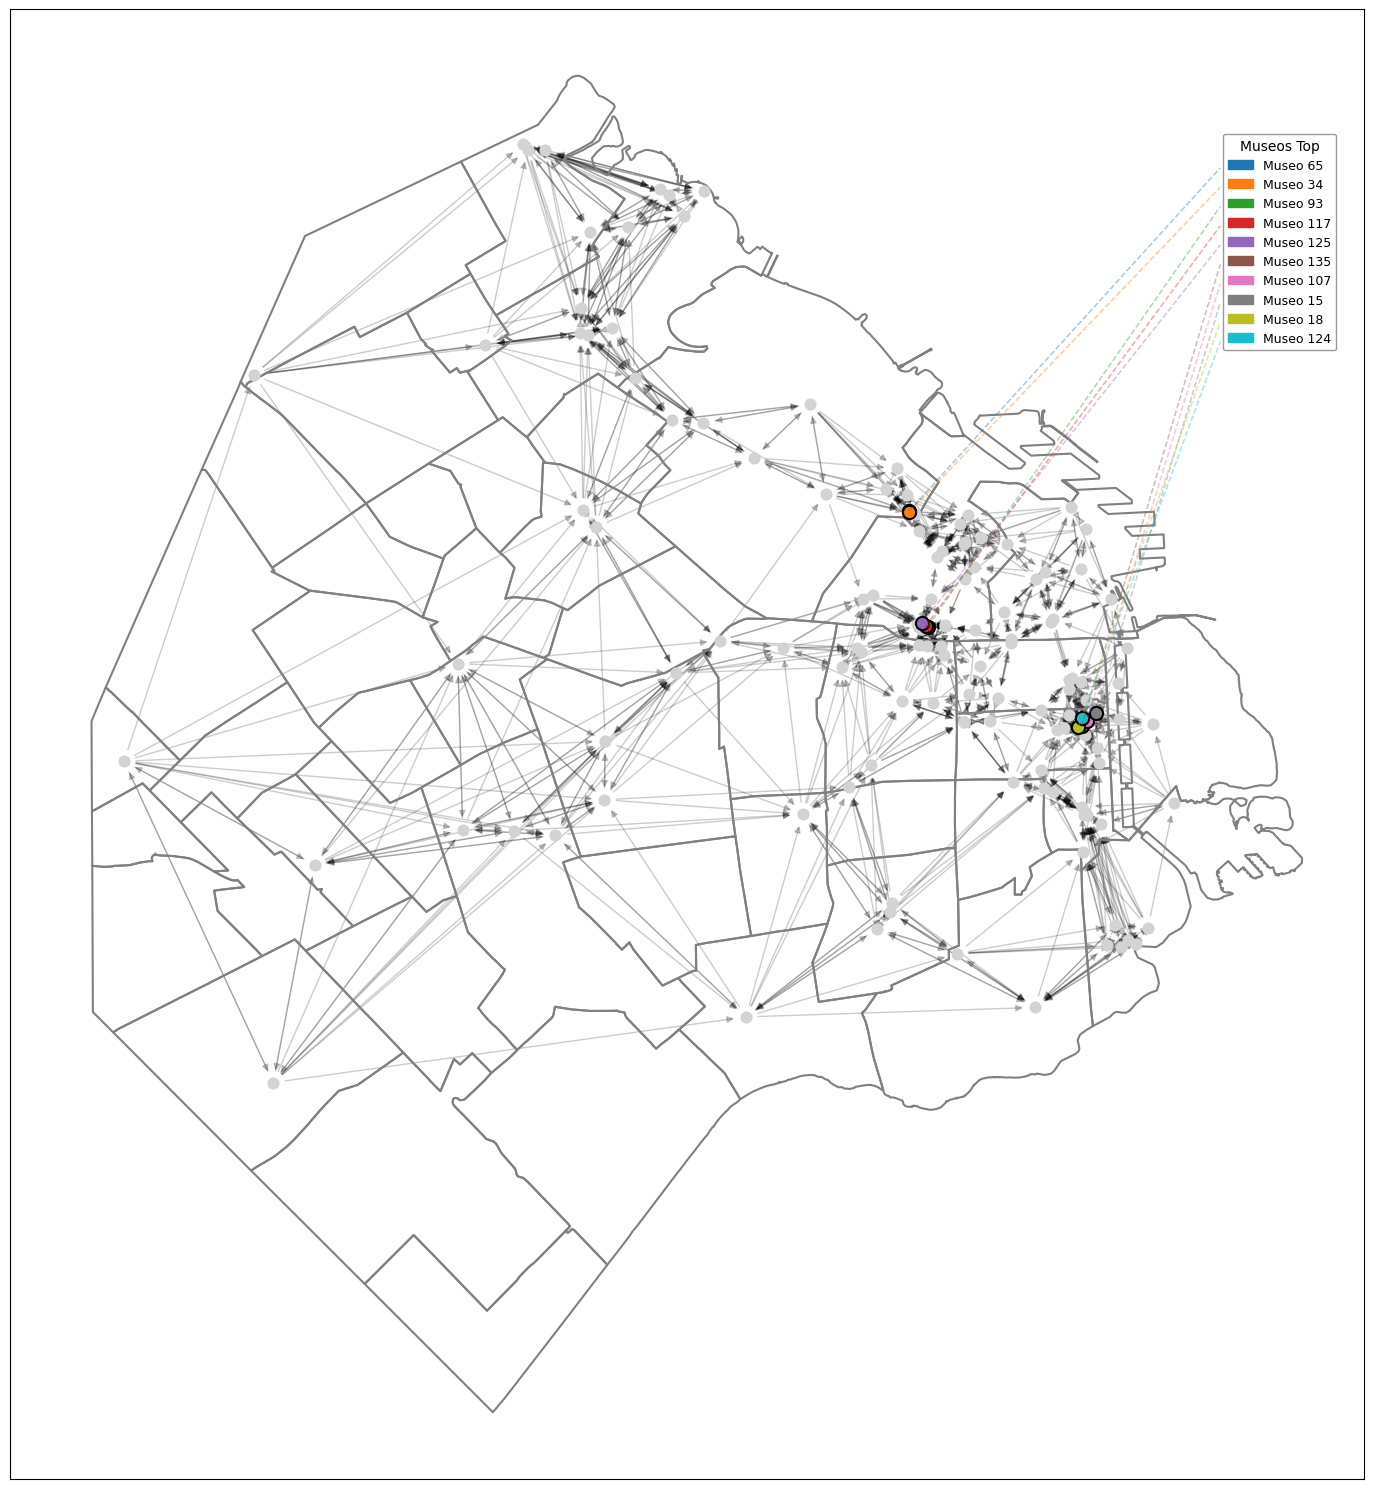

In [ ]:



# controles para mover las flechas
offset_horizontal = 10
offset_primera_linea = 50  # Desplazamiento vertical para la primera línea (desde arriba)
offset_ultima_linea = 30  # Desplazamiento vertical para la última línea (desde abajo)

# Armado del grafo base
G = nx.from_numpy_array(A, create_using=nx.DiGraph)
coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: v for i, v in enumerate(zip(coords['x'], coords['y']))}


todos_los_top_museos = set()
for m_value, top_indices in top_museos_por_m.items():
    todos_los_top_museos.update(top_indices)

# Ordenar museos según ubicación
orden_museos = [65, 34, 93, 117, 125, 135, 107, 15, 18, 124]
todos_los_top_museos_ordenados = []

for museo_id in orden_museos:
    if museo_id in todos_los_top_museos:
        todos_los_top_museos_ordenados.append(museo_id)
        todos_los_top_museos.remove(museo_id)


todos_los_top_museos_ordenados.extend(list(todos_los_top_museos))

todos_los_top_museos = todos_los_top_museos_ordenados

paleta = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]

# Asignar un color a cada museo top
colores_museos = {}
for i, museo_idx in enumerate(todos_los_top_museos):
    colores_museos[museo_idx] = paleta[i % len(paleta)]

# Nodos regulares (no están en ningún top)
nodos_regulares = [i for i in range(len(coords['x'])) if i not in todos_los_top_museos]

fig, ax = plt.subplots(figsize=(15, 15))
barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)

# Dibujar nodos regulares
nx.draw_networkx_nodes(G, G_layout,
                      nodelist=nodos_regulares,
                      node_size=60,
                      node_color='lightgray',
                      ax=ax)

# Dibujar conexiones
nx.draw_networkx_edges(G, G_layout, alpha=0.2, ax=ax)

# Dibujar cada museo top con su color asignado
for museo_idx in todos_los_top_museos:
    nx.draw_networkx_nodes(G, G_layout,
                         nodelist=[museo_idx],
                         node_size=90,
                         node_color=[colores_museos[museo_idx]],
                         edgecolors='black',
                         linewidths=1.5,
                         ax=ax)

# Crear leyenda para cada museo top
legend_handles = []
for museo_idx in todos_los_top_museos:
    nombre_museo = f"Museo {museo_idx}"

    # Crear texto detallado sobre su ranking en cada valor de m
    rankings_info = []
    for m_value, top_indices in top_museos_por_m.items():
        if museo_idx in top_indices:
            rank = list(top_indices).index(museo_idx) + 1
            rankings_info.append(f"m={m_value} (#{rank})")

    legend_text = f"{nombre_museo}"

    # Añadir a la leyenda
    legend_handles.append(mpatches.Patch(color=colores_museos[museo_idx], label=legend_text))

# Determinar límites de datos para encontrar una buena posición dentro del gráfico
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Posicionar la leyenda en el lado derecho
legend_x = xlim[0] + (xlim[1] - xlim[0]) * 1.11
legend_y = ylim[0] + (ylim[1] - ylim[0]) * 0.95

# Convertir coordenadas de datos a coordenadas normalizadas para bbox_to_anchor
legend_coords_display = ax.transData.transform([(legend_x, legend_y)])[0]
legend_coords_figure = fig.transFigure.inverted().transform(legend_coords_display)

leg = plt.legend(handles=legend_handles,
                bbox_to_anchor=(legend_coords_figure[0], legend_coords_figure[1]),
                loc='center',
                fontsize=9,
                frameon=True,
                title="Museos Top",
                facecolor='white',
                edgecolor='gray',
                framealpha=0.8)

plt.draw()

legend_bbox = leg.get_window_extent(fig.canvas.get_renderer())

y_primera = legend_bbox.y0 + legend_bbox.height - offset_primera_linea
y_ultima = legend_bbox.y0 + offset_ultima_linea

# Punto de anclaje horizontal (con offset manual)
x_pos = legend_bbox.x0 + offset_horizontal  # Ajuste manual izquierda/derecha

# Rango vertical efectivo definido por las líneas ajustadas
rango_efectivo = y_primera - y_ultima

# Total de museos para calcular el espaciado
total_museos = len(todos_los_top_museos)

# Para cada museo top, conectar con la leyenda
for idx, museo_idx in enumerate(todos_los_top_museos):
    # Obtener la posición del nodo
    node_pos = G_layout[museo_idx]

    if total_museos > 1:
        # Factor de interpolación (0 para el primero, 1 para el último)
        factor = idx / (total_museos - 1)
        # Interpolación lineal entre la posición de la primera y última línea
        y_pos = y_primera - (factor * rango_efectivo)
    else:
        # Solo hay un museo, colocarlo en el centro
        y_pos = (y_primera + y_ultima) / 2


    patch_pos_data = ax.transData.inverted().transform([(x_pos, y_pos)])[0]

    ax.plot([node_pos[0], patch_pos_data[0]],
            [node_pos[1], patch_pos_data[1]],
            color=colores_museos[museo_idx],
            linewidth=1.1,
            alpha=0.4,
            linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
# Calculamos PageRank para cada alfa ---
A = construye_adyacencia(D, m)
pageranks_por_alfa = {}

for alfa in valores_alfa:
    p = f.calcula_pagerank(A, alfa)
    pageranks_por_alfa[alfa] = p

# Tabla con Top 3 museos para cada alfa ---
top_museos_por_alfa = {}

for alfa in valores_alfa:
    p = pageranks_por_alfa[alfa]
    top_indices = np.argsort(p)[-3:][::-1]  # orden descendente
    top_museos_por_alfa[alfa] = top_indices

tabla_top_alfa = pd.DataFrame.from_dict(
    top_museos_por_alfa,
    orient="index",
    columns=["Top 1", "Top 2", "Top 3"]
)

tabla_top_alfa.index.name = "α"
display(tabla_top_alfa)


Top 1  Top 2  Top 3
α                            
0.857143    124     15    135
0.800000    124     15    135
0.666667    124     15    135
0.500000    124     15    135
0.333333    124     15    135
0.200000    124    135     15
0.142857    124    106     94

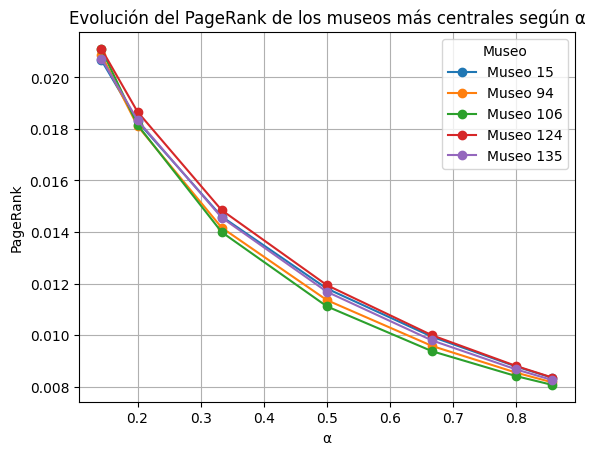

In [ ]:
# 1. Unir todos los museos que fueron Top 3 en al menos un α
museos_centrales = sorted(set(i for top in top_museos_por_alfa.values() for i in top))

# 2. Armar el DataFrame con la evolución
df_evolucion_alpha = pd.DataFrame({
    f"Museo {i}": [pageranks_por_alfa[alfa][i] for alfa in valores_alfa]
    for i in museos_centrales
}, index=valores_alfa)

# 3. (opcional) Renombrar con nombres reales si tenés el DataFrame `museos` con una columna "nombre"
# nombres = [museos.iloc[i]["nombre"] for i in museos_centrales]
# df_evolucion_alpha.columns = nombres

# 4. Graficar
df_evolucion_alpha.plot(marker='o')
plt.xlabel("α")
plt.ylabel("PageRank")
plt.title("Evolución del PageRank de los museos más centrales según α")
plt.grid(True)
plt.legend(title="Museo")
plt.show()

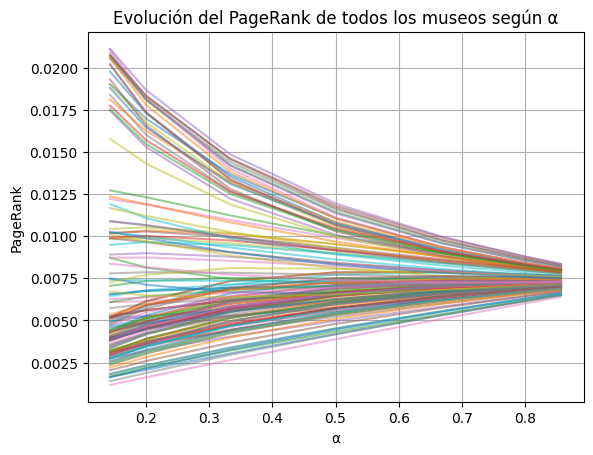

In [ ]:
# Creamos un DataFrame con todos los valores de PageRank
df_a_todos = pd.DataFrame({
    alfa: pageranks_por_alfa[alfa] for alfa in valores_alfa
}).T

df_a_todos.columns = [f"Museo {i}" for i in range(df_a_todos.shape[1])]

# Graficamos
df_a_todos.plot(legend=False, alpha=0.5)
plt.xlabel("α")
plt.ylabel("PageRank")
plt.title("Evolución del PageRank de todos los museos según α")
plt.grid(True)
plt.show()


## Análisis de la variación de museos a medida que aumenta el factor de amortiguamiento

A medida que aumenta el factor de amortiguamiento hay más chances que una persona no siga un recorrido de ir hacia los museos más cercanos y se dirijan a otros museos. Por esta razón a medida que aumenta la probabiliad de no ir hacia el museo más cercano la diferencia relativa entre los rankings se va disminuyendo.

Sin embargo, los cambios de posición no son grandes. Estos cambios tienen una posible explicación.

Cuando un museo es "apuntado" por muchos museos que no son importantes, el ranking en pagerank no va a ser el más bajo, porque es apuntado por varios museos, pero tampoco es tan alto, porque es apuntado por museos no tan importantes. Ahora bien, si aumenta la probabilidad de ir a un museo de manera aleatoria, entonces es más facil llegar a uno de esos museos que no son importantes, y por eso luego es facil llegar a este museo que es apuntado por estos otros museos no importantes.  En cambio, cuando la probabilidad de ir a un museo al azar es más baja, solo se tiende a llegar a estos museos pasando por museos importantes y más interconectados. Este caso hipotético explica por qué es posible los cambios de posiciones en pagerank cuando se modifica el factor de amortiguamiento.

En este caso la red es tan compleja debido a la cantidad de museos que es bastante dificil explicar exactamente de qué manera se está dando este tipo de fenómenos.


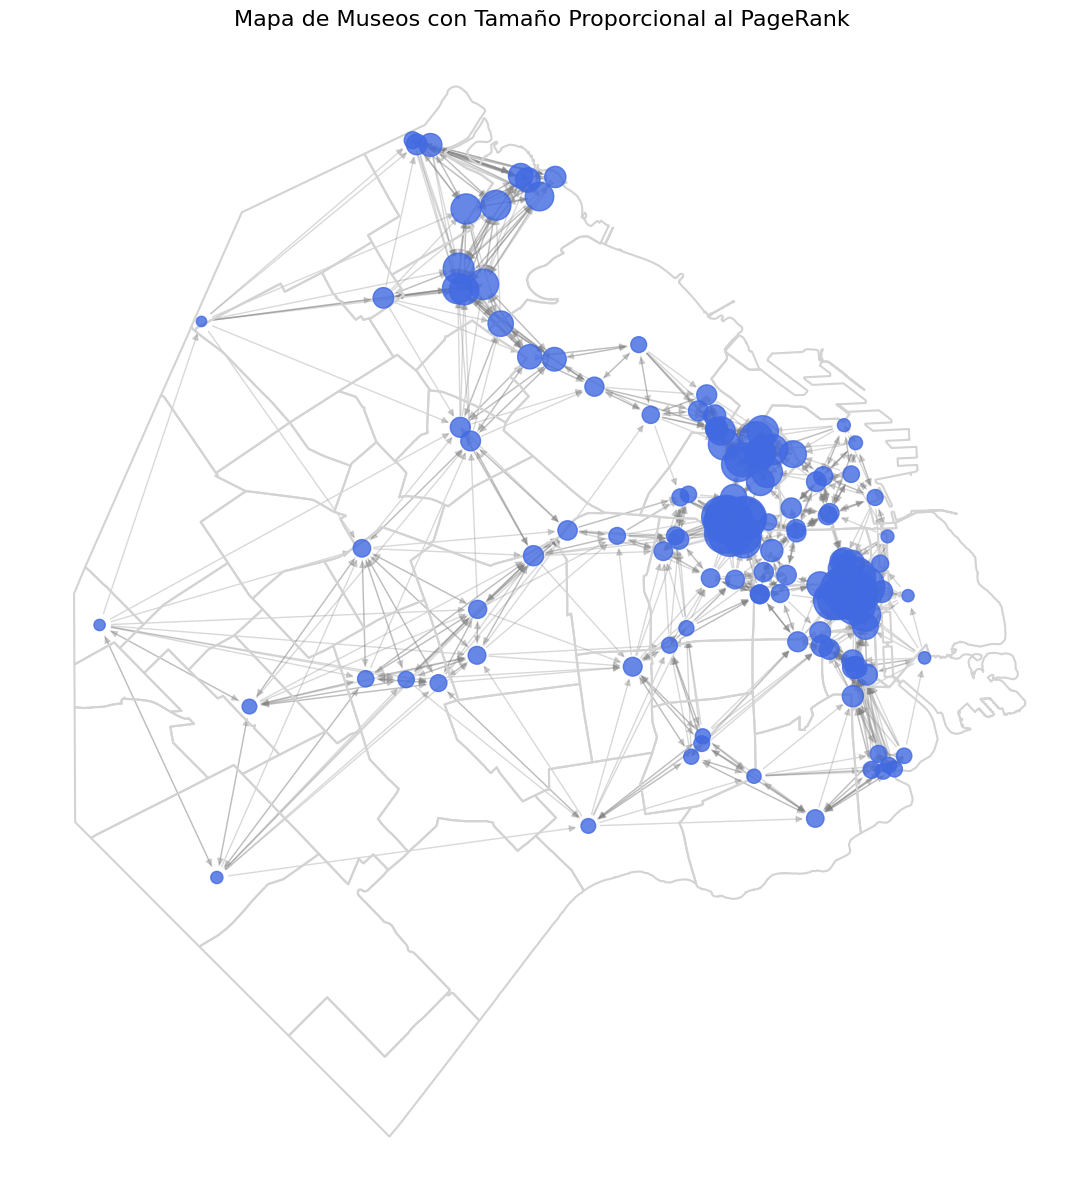

In [ ]:
# Normalizamos el tamaño de los nodos para que se vean bien
sizes = 1000 * (p / np.max(p))

fig, ax = plt.subplots(figsize=(15, 15))

barrios.to_crs("EPSG:22184").boundary.plot(color='lightgray', ax=ax)

# Dibujamos los nodos (museos) con tamaños proporcionales a PageRank
nx.draw_networkx_nodes(G, G_layout, node_size=sizes, node_color='royalblue', alpha=0.8, ax=ax)

# Dconexiones (aristas)
nx.draw_networkx_edges(G, G_layout, edge_color='gray', alpha=0.3, ax=ax)

plt.title("Mapa de Museos con Tamaño Proporcional al PageRank", fontsize=16)
plt.axis("off")
plt.show()

Con este mapa se puede ver claramente que a medida que hay más museos cercanos crece la importancia en pageRank. Parecen haber varias zonas que son importantes. La principal en Recoleta cerca de Balvanera, luego parece haber otra muy importante en el borde entre entre Monserrat y San Nicolas y otra en el borde entre Recoleta y Palermo.  También hay puntos con una conectividad media a los alrededores de Belgrano. El sur y el oeste de la ciudad carecen de mucha oferta en la noche de los museos.

> Agregar bloque entrecomillado



## Punto 4 CORREGIDO:

$v_0 = v$ representa el número inicial de participantes que ingresan a la red en el primer turno o movimiento.

Después de $k$ movimientos, la distribución de visitantes está dada por $C^k.v_0$.



*   Estado inicial: $C^0v_0 =v_0$
*   Luego del primer movimeinto:
$C^1v_0 = v_1$
*   ...
*   Después del $(r-1)$-ésimo movimiento:
$C^{r-1}v_0 = v_{r-1}$


$ w = \underbrace{v_0}_{\text{etapa }0}  + \underbrace{\mathcal{C}v_0}_{\text{etapa }1}  + \underbrace{\mathcal{C}^2v_0}_{\text{etapa }2}  + \cdots  + \underbrace{\mathcal{C}^{r-1}v_0}_{\text{etapa }r-1}$

Esto es equivalente a:
$w = \sum^{r-1}_{k=0} C^kv_0$

Teniendo en cuenta que según la consigna $B = \sum^{r-1}_{k=0} C^k$

Nos queda que:
$w = Bv_0$

Entonces si queremos encontrar $v$ como pide la consigna, multiplicamos por $B^{-1}$ ambos lados y obtenemos:


$w = Bv$

$B^{-1}w = B^{-1}Bv$

$B^{-1}w = Iv$

$B^{-1}w = v$

$v = B^{-1}w$

Por lo que mostramos que muestre que el vector $v$, que tiene en su componente $v_i$ el número de personas que tuvo al museo $i$
como punto de entrada a la red, puede estimarse como $v = B^{-1}w$.

## Punto 5:

In [ ]:




visitas = pd.read_csv('visitas.txt', sep="\t", names=["datos"]) #leo el txt visitas
w=np.arange(len(visitas))
#cargamos los datos en el vector w
for x in range(0,len(visitas),1):
        w[x]=visitas.iloc[x]['datos']
#calculamos Matriz C continua
C=f.calcula_matriz_C_continua(D)
#calculamos B para la resolver v=B^-1 w
B=f.calcula_B(C,3)
#resolvemos la ecuación 5
v=f.calcula_Pto_de_entrada(B,w) #v=B^-1 w
cant_total=f.norma_Uno(v)

display(cant_total)




np.float64(50330.93036829436)

## Punto 6:

Vamos a buscar la cota superior del error relativo para la sollución del sistema $Bv=w$.

Matemáticamente como dice el enunciado sería:
$\frac{\|\Delta v\|}{\|v\|} \le \kappa(B) \cdot \frac{\|\Delta w\|}{\|w\|}$

En esencia, estamos calculando qué tan confiable es nuestra estimación del número de personas que iniciaron su recorrido en cada museo (v), sabiendo que los datos de entrada que usaste (el número total de visitas w) no son perfectos y tienen un error del 5%.

In [ ]:
# cota superior para ||Δw|| / ||w|| (5% de error → multiplicamos por 1.05
error = 1.05 #cota superior

# Calculamos el número de condición de la matriz B (condición del sistema)
cond_B=f.calcular_condicion(B)

# Estimamos una cota superior para el error relativo en v
# ||Δv|| / ||v|| ≤ κ(B) * (||Δw|| / ||w||)
error_estimacion_V=cond_B*error


display(error_estimacion_V)

np.float64(5.304359735498252)

La cota superior del error relativo en v es:

Error relativo en v $\leq$ $Cond_1(B) \times$
Error relativo en $w$ $=$ $5,304 \times 0,05 =
0,2652$.

Esto equivale a 26.52%.

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, '8'),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19

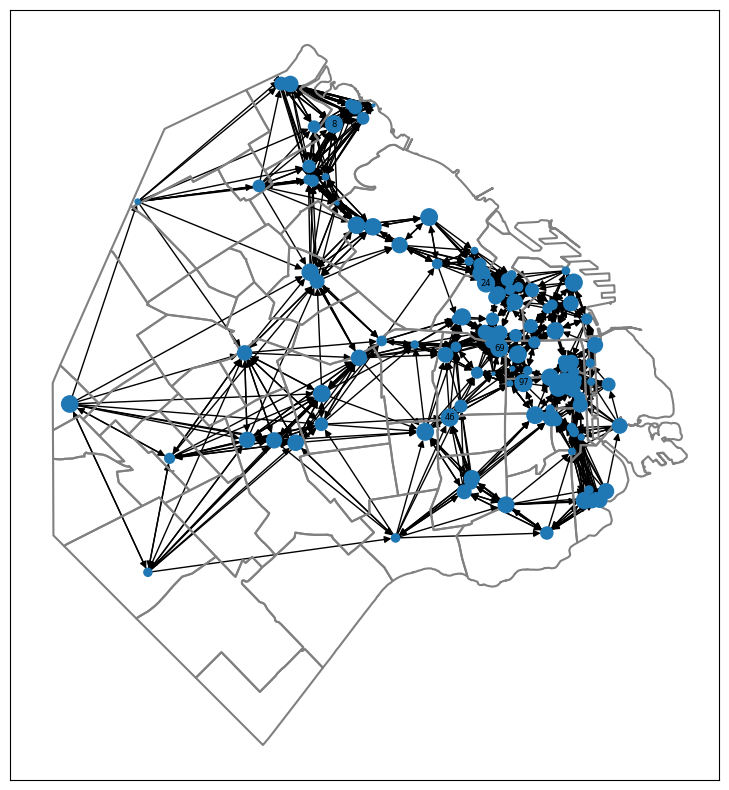

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

**Punto 1. Autovectores y autovalores de L y R**

$\quad$  a. Sea $L = K - A$,  con
  $L, K, A \in {R}^{nxn}$

$$
L = \begin{pmatrix}
k_1 & 0   & \cdots & 0 \\
0   & k_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0   & 0   & \cdots & k_n
\end{pmatrix} -
 \begin{pmatrix}
0 & a_{1,2}   & \cdots & a_{1,n} \\
a_{2,1}   & 0 & \cdots &  a_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n,1}   & a_{n,2}   & \cdots & 0
\end{pmatrix}
$$

$$
 = \begin{pmatrix}
k_1 & -a_{1,2}   & \cdots & - a_{1,n} \\
-a_{2,1}   & k_2 & \cdots & -a_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
-a_{n,1}   & -a_{n,2}   & \cdots & k_n
\end{pmatrix}
$$
$$
$$
Si ahora tomamos al vector $1 \in R^n$ y lo multiplicamos por $L$ obtenemos:

$
\begin{align*}
\begin{pmatrix}
k_1 & -a_{1,2}   & \cdots & - a_{1,n} \\
-a_{2,1}   & k_2 & \cdots & -a_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
-a_{n,1}   & -a_{n,2}   & \cdots & k_n
\end{pmatrix} *
\begin{pmatrix}
1 \\
1 \\
\vdots\\
1
\end{pmatrix} = \begin{pmatrix}
k_1 - \sum_{j=1, j \neq i}^{j=n} a_{1,j}\\
k_2 - \sum_{j=1, j \neq i}^{j=n} a_{2,j} \\
\vdots \\
k_n - \sum_{j=1, j \neq i}^{j=n} a_{n,j}
\end{pmatrix} = \begin{pmatrix}
0 \\
0 \\
\vdots\\
0
\end{pmatrix}
\end{align*}$

Ya que la sumatoria planteada es justamente el $k_{i}$ en cada caso. Por lo que

$$
\begin{align*}
\begin{pmatrix}
0 \\
0 \\
\vdots\\
0
\end{pmatrix} = 0
\begin{pmatrix}
1 \\
1 \\
\vdots\\
1
\end{pmatrix}
\end{align*}
$$

Entonces, 0 es autovalor asociado al autovector $1$ en $L$.
$$
$$$$$$

Luego, sea $R = A - P$ con $R$:

$$
R = \begin{pmatrix}
0 & a_{1,2}   & \cdots & a_{1,n} \\
a_{2,1}   & 0 & \cdots &  a_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n,1}   & a_{n,2}   & \cdots & 0
\end{pmatrix} - \frac{1}{2E}
  \begin{pmatrix}
k_{1,1} & k_{1,2}   & \cdots & k_{1,n} \\
k_{2,1} & k_{2,2}   & \cdots & k_{2,n} \\
\vdots & \vdots & \ddots & \vdots \\
k_{n,1} & k_{n,2}   & \cdots & k_{n,n} \\
\end{pmatrix}
$$
$$
$$
$$\begin{align*}
con \quad k_{i,j} = k_i.k_j
\end{align*}$$

$\quad$Teniendo:

$$\begin{align*}R_{i,j} = a_{i,j} - \frac{k_{i}.k_{j}}{2E}\end{align*}$$

Por lo tanto, el $i$-ésimo elemento del vector $R \cdot \mathbf{1}$ será:

$$
\begin{align*}
(R \cdot \mathbf{1})_{i} &= (a_{i,1} - \frac{k_{i}k_{1}}{2E}) + (a_{i,2} - \frac{k_{i}k_{2}}{2E}) + \dots + (a_{i,n} - \frac{k_{i}k_{n}}{2E}) \\
&= k_{i} - \frac{k_{i}}{2E} \sum_{j=1}^{n} k_{j} \\
&= k_{i} - \frac{k_{i}}{2E} \cdot 2E \\
&= k_{i} - k_{i} = 0
\end{align*}
$$

Por lo que, cada elemento de $R*1$ será 0:

$$
\begin{align*}(R * 1) = \begin{pmatrix}
0 \\
0 \\
\vdots\\
0
\end{pmatrix} = 0
\begin{pmatrix}
1 \\
1 \\
\vdots\\
1
\end{pmatrix}\end{align*}
$$
Entonces, 0 es autovalor asociado al autovector $1$ en $R$ también.
$$
$$$$$$

$\quad$  b. Sea $M$ una matriz simétrica con dos autovectores $v_1$ y $v_2$, con autovalores asociados $\lambda_{1}$ y $\lambda_{2}$, respectivamente, tales que $v_1 \neq v_2 \land \lambda_{1} \neq \lambda_{2}$.

  Entonces:

\begin{align*}
 M v_2 &= \lambda_2 v_2  \\
 M v_1 &=  \lambda_1 v_1
\end{align*}

Por lo que:

\begin{align*}
v_1^t M v_2 &= v_1^t \lambda_2 v_2 \tag{1} \\
v_2^t M v_1 &= v_2^t \lambda_1 v_1 \tag{2}
\end{align*}


Entonces, si trasponemos la primera igualdad:

$$
\begin{align*}
  (v_1^T M v_2)^T &= (v_1^T \lambda_2 v_2)^T \\
                  &= v_2^T M^T v_1 \\
                  &= v_2^T M v_1 \quad \text{(ya que } M^T = M \text{ por hipótesis)} \\
                  &= \lambda_2 v_2^T v_1
\end{align*}
$$


Además, por la ecuación (2) tenemos:

$$
\begin{align*}
v_2^t M v_1 &= v_2^t \lambda_1 v_1
\end{align*}
$$

Entonces, obtenemos:

$$
\begin{align*}
\lambda_2 v_2^T v_1 &= \lambda_1 v_2^T v_1 \\
\lambda_2 v_2^T v_1 - \lambda_1 v_2^T v_1 &= 0 \\
(\lambda_2 - \lambda_1) v_2^T v_1 &= 0 \quad \text{(como } \lambda_2 \neq \lambda_1 \text{, por hipótesis)} \\
v_2^T v_1 &= 0
\end{align*}
$$

  c. Corrección:

  Sabemos por los puntos anteriores que $1$ es autovector asociado a $R,L$ con autovalor $0$. Si tomamos un autovector $v$ con autovalor $\lambda \neq 0$, entonces, también por los puntos anteriores, sabemos que $v$ es ortogonal a $1$, por lo que:

  $$
\begin{align*}
  1^t. v = 0 \text{, es decir, }
  \sum_{i=1}^{n} v_i = 0
\end{align*}
$$





**Punto 2. Extensiones del método de la potencia**

$\quad$ a. **Shifting de autovalores:**

Sea $M \in \mathbb{R}^{n \times n}$ diagonalizable, con autovalores:

$$
\lambda_1 \geq \lambda_2 \geq \dots \geq \lambda_n
$$

y $v_i$ el autovector asociado a $\lambda_i$.

Si hacemos el producto:

$$
\begin{align*}
(M + \mu I)v_i &= Mv_i + \mu Iv_i \\
               &= \lambda_i v_i + \mu v_i \\
               &= (\lambda_i + \mu) v_i
\end{align*}
$$

Por lo tanto, si definimos $\gamma_i = \lambda_i + \mu$, tenemos que $\gamma_i$ es el autovalor asociado a $v_i$ para la matriz $(M + \mu I)$.

Luego, si $\gamma_i \neq 0 \quad \forall i$, se obtiene una base de autovectores $\{v_1, \dots, v_n\}$ asociados a los $\gamma_i $. Entonces, al tener una base de autovectores, $M + \mu I$ es diagonalizable y, además, al tener todos sus autovalores no-nulos, se tiene que $M + \mu I$ es  invertible, como queríamos ver.

$\quad$ b. **Método de la potencia inverso:**

Primero, demostraremos que $L + \mu I$ es invertible, con $\mu > 0$.

Sabemos que la matriz  $L$ es Simétrica Definida Positiva (SDP). También, sabemos que el autovalor más chico de $L$ es $\lambda = 0$, con $1$ como autovector asociado, como observamos el puntos anteriores.

Por lo tanto, los autovalores de $L$ cumplen:
$$
0 = \lambda_n < \lambda_n-1 \leq \dots \leq \lambda_1
$$

Al sumar $\mu I$ a $L$, todos los autovalores se desplazan, como vimos en puntos anteriores:

$$
\gamma_i = \lambda_i + \mu > 0 \quad \forall i
$$

Entonces, $L + \mu I$, también es simétrica definida positiva, ya que, si para todo $x$, se tiene que:
$$
\begin{align*}
si \quad x^T.L.x > 0, \\
⇒\quad  x^T.(L + \mu I).x = \\
 x^T.L.x + \mu.||x||_2^2 > 0
\end{align*}
$$
y por lo tanto, **invertible**, ya que al cumplirse la ecuación:
$$
\begin{align*}
 \quad x^T.(L + \mu I).x > 0, \\
\end{align*}
$$

se tiene que no hay nada en $Nu(L + \mu I)$ pues, si hubiera, se cumpliría que $(L + \mu I)x = 0$, que llegaria a

$$
\begin{align*}
 \quad x^T.(L + \mu I).x =x^T. 0 = 0, \\
\end{align*}
$$

Lo que implicaría un absurdo.

Segundo, vamos por el metodo de la potencia inverso:

La semilla de la que partiremos es un $w$ tal que no tiene ninguna componente nula, ya que esto podria anular alguno de los autovectores en las iteraciones.

Aplicar el método de la potencia a $(L + \mu I)^{-1}$ retornará el autovector asoiciado a su autovalor de mayor módulo, que corresponde con el autovector asociado al autovalor de menor m´dulo de $(L + \mu I)$. Dicho autovalor es $γ_i = \frac{1}{λ_i+ \mu}$ (con $λ_i+ \mu \neq 0 \forall i$), y es el inverso al autovalor de menor modulo para $(L + \mu I)$.

Luego, si el autovector de $(L + \mu I)^{-1}$ es único, su valor será $1$ de autovalor 1/μ.

$\quad$ c. **. Deflación de Hotelling:**

Sea $M$ simiétrica y sea $\tilde{M} = M - λ_i \frac{v_1v_1^t}{v_1^tv_1}$.

Sea $\beta = \{v1, ... ,v_n\}$ una base de autovectores de $M$.

Entonces, para $v_1$ tenemos:

$$
\begin{align*}
\tilde{M}v_1  &=  (M - λ_1 \frac{v_1v_1^t}{v_1^tv_1})v_1 \\
 &=  Mv_1 - λ_1 \frac{v_1v_1^t}{v_1^tv_1}v_1\\
 &=  λ_1v_1 - λ_1v_1\\
  &=  0
\end{align*}
$$

y para $v_j, j \neq 1$:

$$
\begin{align*}
\tilde{M}v_j  &=  (M - λ_j \frac{v_1v_1^t}{v_1^tv_1})v_j \\
 &=  Mv_j - λ_j \frac{v_1v_1^t}{v_1^tv_1}v_j\\
 &=  λ_jv_j - λ_jProy_{v_1}(v_j)\\
  &=  λ_jv_j - 0 \quad \text{ya que como vimos, distintos autovectores son ortogonales} \\
   &=  λ_jv_j
\end{align*}
$$

Entonces, demostramos que los autovectores y autovalores son exactamente los mismos en $M$ y en $\tilde{M}$, a excepcion de $λ_1$, pero que el autovector dominante de $M$ es el que se *deflaciona*, siendo que ahora ya no es $λ_1$ el autovalor de mayor módulo, sino el que antes era el segundo.


**Punto 3**

**a.**

Son los métodos del template que usamos a continuación.

**b.**

Aplicaremos los metodos desarrollados en el template de funciones usando de ejemplo la matriz A del grafo de las slides.

La misma es
$$
\begin{align*}
A = \begin{bmatrix}
0 & 1 & 1 & 1 & 0 & 0 & 0 & 0 \\
1 & 0 & 1 & 1 & 0 & 0 & 0 & 0 \\
1 & 1 & 0 & 1 & 0 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 1 & 1 & 1 \\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 \\
0 & 0 & 0 & 0 & 1 & 1 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 1 & 1 & 0
\end{bmatrix}
\end{align*}
$$

Para calcular L y R, usamos los métodos **calcula_L(A)** y **calcula_R(A)**


In [ ]:
A = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 1, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
])

L = f2.calcula_L(A)
np.set_printoptions(precision=2, suppress=True)
R = f2.calcula_R(A)

print("Matriz Laplaciano A: \n\n", L , "\n\n\n", "Matriz de Modularidad R:\n\n", R)

Matriz Laplaciano A: 

 [[ 3 -1 -1 -1  0  0  0  0]
 [-1  3 -1 -1  0  0  0  0]
 [-1 -1  4 -1  0 -1  0  0]
 [-1 -1 -1  4 -1  0  0  0]
 [ 0  0  0 -1  4 -1 -1 -1]
 [ 0  0 -1  0 -1  4 -1 -1]
 [ 0  0  0  0 -1 -1  3 -1]
 [ 0  0  0  0 -1 -1 -1  3]] 


 Matriz de Modularidad R:

 [[-0.32  0.68  0.57  0.57 -0.43 -0.43 -0.32 -0.32]
 [ 0.68 -0.32  0.57  0.57 -0.43 -0.43 -0.32 -0.32]
 [ 0.57  0.57 -0.57  0.43 -0.57  0.43 -0.43 -0.43]
 [ 0.57  0.57  0.43 -0.57  0.43 -0.57 -0.43 -0.43]
 [-0.43 -0.43 -0.57  0.43 -0.57  0.43  0.57  0.57]
 [-0.43 -0.43  0.43 -0.57  0.43 -0.57  0.57  0.57]
 [-0.32 -0.32 -0.43 -0.43  0.57  0.57 -0.32  0.68]
 [-0.32 -0.32 -0.43 -0.43  0.57  0.57  0.68 -0.32]]


Luego, como queremos obtener el segundo autovalor mas chico de **L shifteada** y su autovector asociado, y también el autovalor mas grande de **R** y su respectivo autovector, usamos los métodos calculados **metpotI2(L, mu)** para el primer caso y **metpot1(R)** para el segundo.

In [ ]:
mu = 0.1
np.set_printoptions(precision=2, suppress=True)

segundo_autovector_min_L, segundo_autovalor_min_L,_= f2.metpotI2(L,mu)


vector_max_R ,valor_max_R, _= f2.metpot1(R)

print("Segundo AutoValor mas chico de L: ",round(segundo_autovalor_min_L, 2),
          ", asociado al autovector: ", segundo_autovector_min_L,
          "\n\nAutovalor mas grande de R:",round(valor_max_R, 2),", asociado al autovector: ", vector_max_R)


s_L = np.where(segundo_autovector_min_L >= 0, 1, -1)
s_R = np.where(vector_max_R >= 0, 1, -1)
print("\n\nPartición asociada al segundo autovector de L:", s_L)
print("\nPartición asociada al primer autovector  de R:", s_R)

Segundo AutoValor mas chico de L:  0.76 , asociado al autovector:  [-0.43 -0.43 -0.26 -0.26  0.26  0.26  0.43  0.43] 

Autovalor mas grande de R: 2.56 , asociado al autovector:  [-0.39 -0.39 -0.31 -0.31  0.31  0.31  0.39  0.39]


Partición asociada al segundo autovector de L: [-1 -1 -1 -1  1  1  1  1]

Partición asociada al primer autovector  de R: [-1 -1 -1 -1  1  1  1  1]


Se observa, que el resultado termina siendo el mismo, que la partición del grafo de ejemplo son dos comunidades de 4 nodos cada una, con los nodos 1-2-3-4 por un lado, y los nodos 5-6-7-8 por otro.

Coincide con la partición esperada del grafo ya que, las conexiones entre pares de nodos de cada segmentación, tienen 3 conexiones mientras que, a las comunidades las unen 2 segmentos, por lo que la partición es la esperada.

El segundo autovalor mas chico de L shifteada se debe a que 0 es el autovalor mas chico de L, y queremos evitar usar este para el laplaciano, por eso es que se utiliza el segundo. Con respecto a la modularidad, el autovector asociado al maximo autovalor de R indica la segmentación que maximiza la modularidad. Esa es la justificación de por qué se usa el minimo autovalor en uno, y el máximo en otro.

**c.**

Ahora, veremos que la partición optima con el Laplaciano con 2 niveles (es decir, $2^2$ comunidades, será subidividir cada comunidad en 2, sin importar cual con cual dentro de estas.

Por otro lado, la modularidad optima indica que la partición es la que vimos antes, dos comunidades de 4.

In [ ]:
#seteamos el seed para que la particion del laplaciano no varíe al ejecutar varias veces.
np.random.seed(42)

particion_l = f2.laplaciano_iterativo(A,2)
print("Particion en 4 grupos a través del Laplaciano: ", particion_l)

particion_q = f2.modularidad_iterativo(A)
print("\nParticion optima a traves de la Modularidad: ",particion_q)


Particion en 4 grupos a través del Laplaciano:  [[0, 3], [1, 2], [4, 6], [5, 7]]

Particion optima a traves de la Modularidad:  [[0, 1, 2, 3], [4, 5, 6, 7]]


**Punto 4**

**Abajo del texto mostramos el código y los gráficos para apoyar lo que decimos**

*Usando la red de museos definida en el TP anterior,
debemos calcular las particiones óptimas usando el método basado en el laplaciano y el método basado en la modularidad. Utilice la matriz de adyacencia A construida usando m = 3, 5, 10, 50, luego de haberla simetrizado.*


$\quad$ Se nos pide ejecutar el siguiente bloque de código y observar que, para $2$ niveles de corte del **Laplaciano** (es decir, va a generar $2^{niveles}$ comunidades, en este caso $4$), los valores con este método oscilan muy poco con las variaciones sobre $m$. Es muy **estable**. La cantidad de comunidades siempre va a ser menor o igual a $2^{niveles}$ y podría ocurrir que hayan menos comunidades que $2^{niveles}$ en caso de que cuando ya separó a una comunidad en 2, quedó un museo aislado que no puede volverse a separar en 2 comunidades. Es decir, el algortimo va separando en dos comunidades de manera iterativa, pero cuando ya una comunidad tiene 1 museo, no va a poder reducirse más.



$\quad$ Pero, se observa que para la **Modularidad**, sí varian los resultados ejecutando dos o mas veces el mismo bloque sin modificar ningún parámetro. Se nos pide procesar una vez el bloque de código a continuacion y observar los valores de Modularidad, fundamentalmente tamaño de comunidad con más museos y cantidad de comunidades. Luego, ejecutarlo nuevamente y observar que el resultado es distinto.

$\quad$ Estas variables, si bien oscilan, lo hacen en un rango que se puede acotar, dando a entender conceptualmente que la clusterización sea interpretada más como la medida de un desvío con respecto a una red aleatoria, y no como una segmentación definitiva.

$\quad$ Observar también, que conforme crece el valor de $m$, estos valores oscilan cada vez menos para la modularidad, asi que ahí también observamos que hay una relación entre ambas. A mayor $m$, menor oscilación en la modularidad.

$\quad$ Por lo dicho, indicamos que la modularidad es más **inestable** que el método del Laplaciano.



*Exploren cómo cambia la estructura de comunidades obtenida usando la modularidad
(en términos de número de comunidades, de su tamaño y de las regiones del mapa que ocupan, así como la estabilidad ante realizaciones) encontrada para distintos valores de m. Comparen visualmente las comunidades obtenidas mediante el laplaciano y la modularidad, buscando un número de niveles que dé una cantidad de comunidades comparable en ambos métodos. Discuta los resultados obtenidos*

$\quad$ En primer lugar, si elegimos una cantidad baja de niveles creemos que con el Laplaciano podríamos buscar obtener una clusterización en regiones abstracta similar que pueda reflejar la intuciión que una persona podría tener cuando separa en regiones. Separando en 2 niveles, el Laplaciano haría 2 veces la división y se obtendrían aproximadamente 4 grupos. Creemos que si agregamos más niveles se fragmentaría mucho al corte del Laplaciano, cuando lo que nos interesa es mostrar contra un corte Laplaciano general y de grandes grupos.

$\quad$ Por lo tanto, elegimos 2 niveles para generar una segmentación de cuatro grupos en el Laplaciano. Contra esto compararemos los resultados de la Modularidad.

$\quad$ Ejecutar el siguiente bloque de código y una vez terime, observar los 8 gráficos que se generarán. Si bien las etiquetas son claras, la idea es en cada par horizontal, comparar un resultado por Modularidad vs uno por Laplaciano, para el mismo valor de $m$ que generó la matriz de adyacencia. Luego, replicar esto para m = 3, 5, 10 y 50.

$\quad$ Como mencionamos en este y puntos anteriores, el Laplaciano es altamente estable, por lo que vemos casi siempre cuatro grandes comunidades, que si bien tienen algunas variaciones, a grandes rasgos es muy similar.

$\quad$ Ahora, yendo a la Modularidad, vemos que siempre genera valores muy distintos de comunidades con un promedio masomenos de 30 comunidaes. Esta cantidad de comunidades suele cambiar altamente incluso cuando se mantienen los inputs de la función. Esto se debe a que el algoritmo depende del método de la potencia que comienza con un vectori incial alteatorio. Por ejemplo, para una conectividad de museos de 5 museos cercanos repetimos varias veces el algoritmo y nos dieron una cantidad de comunidades muy diferentes.

Sin embargo para m = 50 que cuando corremos el código suele generar únicamente dos grupos, aunque dado a que el método de la potencia utiliza un random y no estamos usando un seed podría ser que la proxima vez de un valor distinto.
Pero para los correspondientes a m = 3, 5 y 10 van variando cada vez aunque con un promedio aproximado de comunidades de 30 museos (aunque con mucha varianza).

$\quad$  Para obtener una cantidad similar de comunidades con el lapaciano deberíamos tener 5 niveles, ya que esto nos daría una cota superior de 32 comunidades y dado a la estabilidad del lapaciano podemos esperar que tenga eso o levemente inferior.

$\quad$ Finalmente, para $m = 50$, la **modularidad**  en nuestro caso nos dió una segmentacion de dos grupos, es interesante este resultado porque es donde se encuentra con el **Laplaciano** (si lo hubieramos corrido con niveles = 1), da lo mismo. Se vio también un fenómeno de que a medida que aumenta la cantidad de conexiones entre museos ("museos más cercanos") entonces, va disminuyendo la cantidad de comunidades. Esto sigue a la intuición ya que Intuitivamente si todos se conectasen con todos diríamos que habría un único cluster trivial y no tiene sentido en separarlo en distintas estructuras.

$\quad$ En resumen, dependiendo de lo que estemos buscando, podemos optar por uno u otro método. En particular, parece que el del **Laplaciano** es mas  directo para generar grandes grupos (pocos cortes) y la **Modularidad** puede aprovecharse mas para busquedas estadísticas en la que no estemos buscando una clasificación amplia, sino ahondar mas en los detalles. Con el Laplaciano deberíamos nosotros elegir masomenos la cantidad de grupos que queremos formar mientras que con la Modularidad la cantidad de grupos se eligen "automáticamente".

$\quad$ Que se elijan la cantidad de clusters automáticamente con la modularidad es algo que podría ser beneficioso si no se conoce tanto del dataset. Por otro lado si ya sabemos la cantidad de clusters que queremos parece mejor utilizar el método Laplaciano. Por otra parte, que la cantidad de clusters sea inestable con la modularidad perjudica su fiabilidad, en tanto que si se lo hace de vuelta puede dar otro resultado. Para resolver eso sugerimos utilziar seeds en implementaciones que requieran estabilidad.



In [ ]:

def normalizar_comunidades(comunidades):
    if isinstance(comunidades, list):
        return [c if isinstance(c, (list, tuple)) else [c] for c in comunidades]
    return []

cantidadDeComunidades_lap = []
cantidadDeComunidades_mod = []
tamañoDeComunidadMayor_lap = []
tamañoDeComunidadMayor_mod = []
tamañoMedianaComunidad_lap = []
tamañoMedianaComunidad_mod = []

valores_m = [3, 5, 10, 50]

for m in valores_m:
    A = f.construye_adyacencia(D, m)
    A_prima = 0.5 * (A + np.transpose(A))

    comunidades_lap = f2.laplaciano_iterativo(A_prima, niveles=5)
    cantidadDeComunidades_lap.append(len(comunidades_lap))

    tamaños_lap = []
    for c in comunidades_lap:
      tamaños_lap.append(len(c))

    maxComunidad = max(tamaños_lap)
    tamañoDeComunidadMayor_lap.append(maxComunidad)

    medianaComunidad = np.median(tamaños_lap)
    tamañoMedianaComunidad_lap.append(medianaComunidad)


    comunidades_mod = f2.modularidad_iterativo(A=A_prima)
    cantidadDeComunidades_mod.append(len(comunidades_mod))


    comunidades_mod = normalizar_comunidades(f2.modularidad_iterativo(A=A_prima))

    tamaños_mod_actual = []
    for c in comunidades_mod:
      tamaños_mod_actual.append(len(c))

    maxComunidad = max(tamaños_mod_actual)
    tamañoDeComunidadMayor_mod.append(maxComunidad)

    medianaComunidad = np.median(tamaños_mod_actual)
    tamañoMedianaComunidad_mod.append(medianaComunidad)


















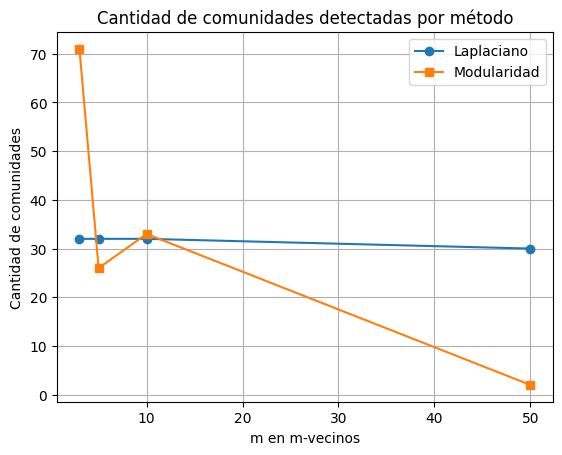

In [ ]:


plt.plot(valores_m, cantidadDeComunidades_lap, marker='o', label='Laplaciano')
plt.plot(valores_m, cantidadDeComunidades_mod, marker='s', label='Modularidad')

plt.xlabel('m en m-vecinos')
plt.ylabel('Cantidad de comunidades')
plt.title('Cantidad de comunidades detectadas por método')
plt.legend()
plt.grid(True)
plt.show()






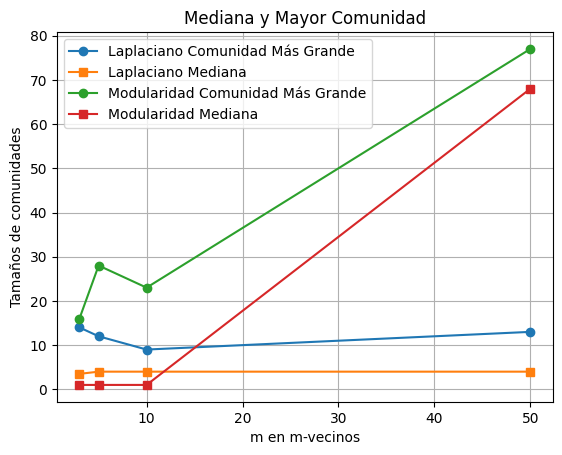

In [ ]:


plt.plot(valores_m, tamañoDeComunidadMayor_lap, marker='o', label='Laplaciano Comunidad Más Grande')
plt.plot(valores_m, tamañoMedianaComunidad_lap, marker='s', label='Laplaciano Mediana')
plt.plot(valores_m, tamañoDeComunidadMayor_mod, marker='o', label='Modularidad Comunidad Más Grande')
plt.plot(valores_m, tamañoMedianaComunidad_mod, marker='s', label='Modularidad Mediana')



plt.xlabel('m en m-vecinos')
plt.ylabel('Tamaños de comunidades')
plt.title('Mediana y Mayor Comunidad')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
valores_m = [3, 5, 10, 50]

# Inicializamos listas para almacenar resultados
cantidadDeComunidades_lap = []
tamañoDeComunidadMayor_lap = []
tamañoMedianaComunidad_lap = []

cantidadDeComunidades_mod = []
tamañoDeComunidadMayor_mod = []
tamañoMedianaComunidad_mod = []

for m in valores_m:
    A = f.construye_adyacencia(D, m)
    A_prima = 0.5 * (A + np.transpose(A))

    print(f"\nResultados para m = {m}:")

    # --- Laplaciano ---
    comunidades_lap = normalizar_comunidades(f2.laplaciano_iterativo(A_prima, niveles=2))
    cantidadDeComunidades_lap.append(len(comunidades_lap))

    tamaños_lap = [len(c) for c in comunidades_lap]
    maxComunidad_lap = max(tamaños_lap)
    tamañoDeComunidadMayor_lap.append(maxComunidad_lap)

    medianaComunidad_lap = np.median(tamaños_lap)
    tamañoMedianaComunidad_lap.append(medianaComunidad_lap)

    print(f"  (Laplaciano) Cantidad de comunidades: {len(comunidades_lap)}")
    print(f"  (Laplaciano) Tamaño de la comunidad con más museos: {maxComunidad_lap}")
    print(f"  (Laplaciano) Tamaño mediano de comunidad: {medianaComunidad_lap}")

    # --- Modularidad ---
    comunidades_mod = normalizar_comunidades(f2.modularidad_iterativo(A=A_prima))
    cantidadDeComunidades_mod.append(len(comunidades_mod))

    tamaños_mod = [len(c) for c in comunidades_mod]
    maxComunidad_mod = max(tamaños_mod)
    tamañoDeComunidadMayor_mod.append(maxComunidad_mod)

    medianaComunidad_mod = np.median(tamaños_mod)
    tamañoMedianaComunidad_mod.append(medianaComunidad_mod)

    print(f"  (Modularidad) Cantidad de comunidades: {len(comunidades_mod)}")
    print(f"  (Modularidad) Tamaño de la comunidad con más museos: {maxComunidad_mod}")
    print(f"  (Modularidad) Tamaño mediano de comunidad: {medianaComunidad_mod}")





Resultados para m = 3:
  (Laplaciano) Cantidad de comunidades: 4
  (Laplaciano) Tamaño de la comunidad con más museos: 56
  (Laplaciano) Tamaño mediano de comunidad: 30.5
  (Modularidad) Cantidad de comunidades: 12
  (Modularidad) Tamaño de la comunidad con más museos: 16
  (Modularidad) Tamaño mediano de comunidad: 12.0

Resultados para m = 5:
  (Laplaciano) Cantidad de comunidades: 4
  (Laplaciano) Tamaño de la comunidad con más museos: 43
  (Laplaciano) Tamaño mediano de comunidad: 36.0
  (Modularidad) Cantidad de comunidades: 35
  (Modularidad) Tamaño de la comunidad con más museos: 28
  (Modularidad) Tamaño mediano de comunidad: 1.0

Resultados para m = 10:
  (Laplaciano) Cantidad de comunidades: 4
  (Laplaciano) Tamaño de la comunidad con más museos: 43
  (Laplaciano) Tamaño mediano de comunidad: 36.0
  (Modularidad) Cantidad de comunidades: 10
  (Modularidad) Tamaño de la comunidad con más museos: 23
  (Modularidad) Tamaño mediano de comunidad: 16.0

Resultados para m = 50:
  (

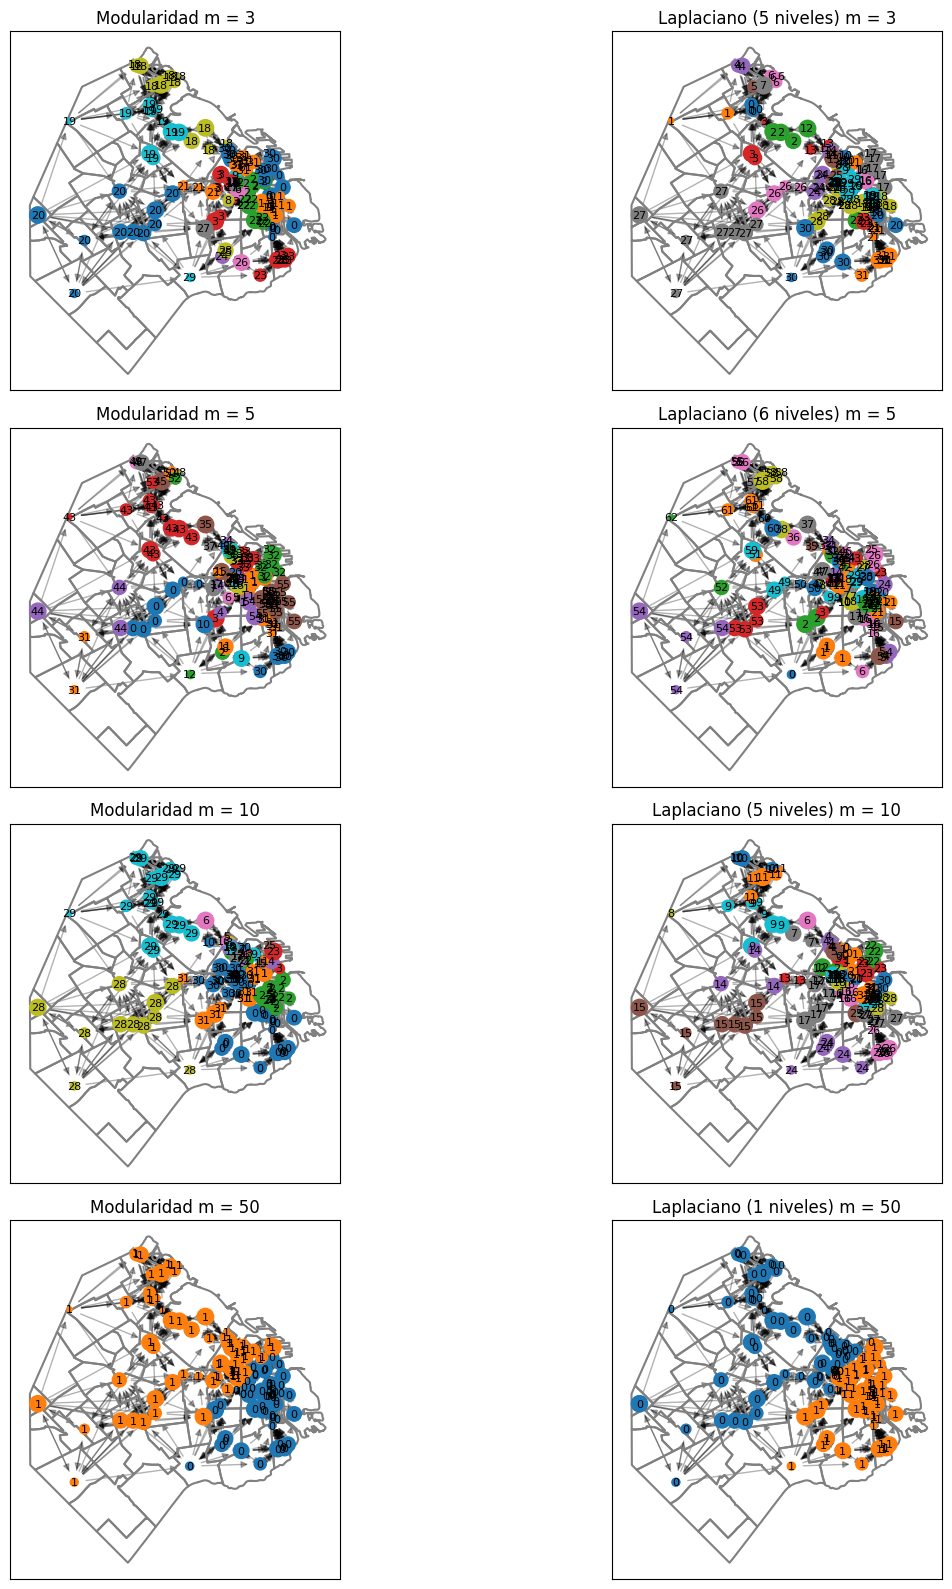

In [ ]:
valores_m = [3, 5, 10, 50]
colores = plt.cm.tab10.colors
fig, axs = plt.subplots(len(valores_m), 2, figsize=(15, 4 * len(valores_m)))

for i, m in enumerate(valores_m):
    # Modularidad
    A = f.construye_adyacencia(D, m)
    A_prima = 0.5 * (A + np.transpose(A))
    comunidades_mod = f2.modularidad_iterativo(A=A_prima)

    # Normalizar comunidades para modularidad
    if isinstance(comunidades_mod, list):
        comunidades_mod = [c if isinstance(c, (list, tuple)) else [c] for c in comunidades_mod]
    else:
        print(f"No se pudo interpretar la salida de comunidades para modularidad con m={m}")
        continue

    colores_nodos = {}
    for idx, comunidad in enumerate(comunidades_mod):
        color = colores[idx % len(colores)]
        for nodo in comunidad:
            colores_nodos[nodo] = color

    labels_comunidad = {}
    for idx, comunidad in enumerate(comunidades_mod):
        for nodo in comunidad:
            labels_comunidad[nodo] = str(idx)

    ax_mod = axs[i, 0]
    ax_mod.set_title(f"Modularidad m = {m}")
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax_mod)

    for idx, comunidad in enumerate(comunidades_mod):
        nx.draw_networkx_nodes(
            G, G_layout,
            nodelist=comunidad,
            node_color=[colores[idx % len(colores)]] * len(comunidad),
            node_size=[pr[n] * factor_escala for n in comunidad],
            ax=ax_mod
        )
    nx.draw_networkx_edges(G, G_layout, alpha=0.3, ax=ax_mod)
    nx.draw_networkx_labels(G, G_layout, labels=labels_comunidad, font_size=8, font_color="k", ax=ax_mod)


    # Laplaciano
    #Vamos a asignar una misma cantidad de niveles que lo que tuvo modularidad para hacer una comparación justa
    num_comunidades = len(comunidades_mod)
    #Y como genera 2^niveles comunidades hay que usar el logaritmo en base 2 y redondearlo.
    niveles_lap = int(np.round(np.log2(num_comunidades)))
    comunidades_lap = f2.laplaciano_iterativo(A_prima, niveles=niveles_lap)



    if isinstance(comunidades_lap, list):
        comunidades_lap = [c if isinstance(c, (list, tuple)) else [c] for c in comunidades_lap]
    else:
        print(f"No se pudo interpretar la salida de comunidades para laplaciano con m={m}")
        continue

    colores_nodos_lap = {}
    for idx, comunidad in enumerate(comunidades_lap):
        color = colores[idx % len(colores)]
        for nodo in comunidad:
            colores_nodos_lap[nodo] = color

    labels_comunidad_lap = {}
    for idx, comunidad in enumerate(comunidades_lap):
        for nodo in comunidad:
            labels_comunidad_lap[nodo] = str(idx)

    ax_lap = axs[i, 1]
    ax_lap.set_title(f"Laplaciano ({niveles_lap} niveles) m = {m}")
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax_lap)

    for idx, comunidad in enumerate(comunidades_lap):
        nx.draw_networkx_nodes(
            G, G_layout,
            nodelist=comunidad,
            node_color=[colores[idx % len(colores)]] * len(comunidad),
            node_size=[pr[n] * factor_escala for n in comunidad],
            ax=ax_lap
        )
    nx.draw_networkx_edges(G, G_layout, alpha=0.3, ax=ax_lap)
    nx.draw_networkx_labels(G, G_layout, labels=labels_comunidad_lap, font_size=8, font_color="k", ax=ax_lap)

plt.tight_layout()
plt.show()





In [ ]:
cantidadDeComunidades_lap_mismoM = []
cantidadDeComunidades_mod_mismoM = []

tamañoDeComunidadMayor_lap_mismoM = []
tamañoDeComunidadMayor_mod_mismoM = []


A = f.construye_adyacencia(D, 5)
A_prima = 0.5 * (A + np.transpose(A))





for i in range(10):
  comunidades_lap_mismoM = f2.laplaciano_iterativo(A_prima, niveles=5)
  cantidadDeComunidades_lap_mismoM.append(len(comunidades_lap_mismoM))

  tamaños_lap = [len(c) for c in comunidades_lap_mismoM]
  maxComunidad_lap = max(tamaños_lap)
  tamañoDeComunidadMayor_lap_mismoM.append(maxComunidad_lap)



  comunidades_mod_mismoM = f2.modularidad_iterativo(A=A_prima)
  comunidades_mod_mismoM = normalizar_comunidades(comunidades_mod_mismoM)
  cantidadDeComunidades_mod_mismoM.append(len(comunidades_mod_mismoM))

  tamaños_mod = [len(c) for c in comunidades_mod_mismoM]
  maxComunidad_mod = max(tamaños_mod)
  tamañoDeComunidadMayor_mod_mismoM.append(maxComunidad_mod)














In [ ]:
print("Vamos a correr con el laplaciano y modularidad 10 veces con los mismos parametros para analizar la estabilidad")
print("")
print("Cantidad de comunidades con el Laplaciano para una misma A  y misma cantidad de niveles")
print(cantidadDeComunidades_lap_mismoM)
print("")
print("Cardinalidad de la comunidad màs grande para el Laplaciano para una misma A  y misma cantidad de niveles")
print(tamañoDeComunidadMayor_lap_mismoM)

print("")

print("")

print("")

print("Cantidad de comunidades con el Modularidad para una misma A ")
print(cantidadDeComunidades_mod_mismoM)
print("")
print("Cardinalidad de la comunidad màs grande para Modularidad para una misma A")
print(tamañoDeComunidadMayor_mod_mismoM)

print("Como se vio más arriba, la modularidad es mucho más inestable.")

Vamos a correr con el laplaciano y modularidad 10 veces con los mismos parametros para analizar la estabilidad

Cantidad de comunidades con el Laplaciano para una misma A  y misma cantidad de niveles
[32, 32, 32, 32, 32, 32, 32, 32, 32, 32]

Cardinalidad de la comunidad màs grande para el Laplaciano para una misma A  y misma cantidad de niveles
[12, 12, 12, 12, 12, 12, 12, 12, 12, 12]



Cantidad de comunidades con el Modularidad para una misma A 
[26, 26, 19, 17, 35, 19, 36, 26, 19, 17]

Cardinalidad de la comunidad màs grande para Modularidad para una misma A
[28, 28, 28, 28, 28, 28, 23, 28, 28, 28]
Como se vio más arriba, la modularidad es mucho más inestable.


**Punto 5.**


Mediante PageRank pudimos encontrar la importancia de museos y logramos ver que en las imágenes que parecen haber centros de alta relevancia cultural en Recoleta, Palermo y el eje Monserrat-San Nicolás, contrastando marcadamente con la menor oferta detectada en las zonas sur y oeste. También vimos como la importancia de estos hubs iba cambiando dependiendo de la cantidad de museos cercanos que utilizabamos.

El segundo Trabajo Práctico nos permitió profundizar en la estructura de estas agrupaciones, la investigación comparó dos algoritmos de clusterización, el método Laplaciano y la optimización de la Modularidad, revelando que ambos actúan como herramientas complementarias con propósitos distintos. Por ejemplo, respecto a la identificaciones de centros importes de museos, podemos ver que utilizando una cantidad de museos 10 y una cantidad de niveles 4 las regiones que a simple vista nos parecían importantes luego de hacer pagerank corresponden con un cluster bien definido por el Laplaciano. El cluster 1 (sur de Recoleta)  y cluster 3 (Borde entre Recoleta y palermo).

También se observó que el método del Laplaciano demostró ser excepcionalmente estable y predecible. También pareció ideal para una segmentación "macro" del territorio en un número predefinido de regiones coherentes. En contraste, la optimización de la Modularidad se presentó como un enfoque más bottom-up, a partir de los datos, cuya mayor fortaleza reside en su capacidad para descubrir el número "natural" de comunidades sin una guía previa.


Otra cosa interesante es que los clusters con estos métodos no siempre se dan exactamente por la cercanía entre museos a un punto, como obtendríamos si utilizaríamos otros algoritmos tipo "k-means" directamente en el mapa. Por ejemplo en algunas instancias ocurrió que todos los museos que están por Libertador desde Nuñez hasta Palermo pertenecían al mismo cluster, (y se forma como una especie de corredor de museos). Algo que con k-means sería muy dificil de lograr ya que es dificil generar ese corredor a través de la cercanía de centroides.

Para poder hacer estos clusters también se exploró el uso del Método de la Potencia. Esto nos permite encontrar los autovalores de modulo más grande a través de un método iterativo. Sin embargo, este metodo utiliza como vector inicial un vector al azar, por lo que puede generar distintos autovectores. Es por eso que también a través de este tp pudimos observar como esto afecta a la inestabilidad de algoritmos tipo el de modularidad iterativo.

